import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np



設定參數

In [9]:
batch_size = 128
learning_rate = 0.0001
num_epochs = 30
img_size = 28
timesteps = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)


載入mnist

In [4]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
indices = list(range(3000))

# 創建子集
train_dataset = Subset(train_dataset, indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34221593.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1195068.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9993037.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9636079.30it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



設定U-NET

In [5]:
class UNet(nn.Module):
     def __init__(self):
        super(UNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )

     def forward(self, x, t):
        return self.net(x)



In [6]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.view(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = extract(alphas_cumprod.sqrt(), t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract((1 - alphas_cumprod).sqrt(), t, x_0.shape)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

def p_losses(denoise_model, x_0, t):
    noise = torch.randn_like(x_0)
    x_noisy = q_sample(x_0, t, noise)
    predicted_noise = denoise_model(x_noisy, t)
    return criterion(predicted_noise, noise)


In [7]:
def p_sample(model, x, t):
    t_index = t[0].item()
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract((1 - alphas_cumprod).sqrt(), t, x.shape)
    sqrt_recip_alphas_t = extract(alphas.sqrt().reciprocal(), t, x.shape)

    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(betas * (1 - alphas_cumprod[t_index - 1]) / (1 - alphas_cumprod[t_index]), t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

def sample(model, image_size, batch_size, channels=1):
    model.eval()
    with torch.no_grad():
        x = torch.randn(batch_size, channels, image_size, image_size).to(next(model.parameters()).device)
        for t in reversed(range(timesteps)):
            t_batch = torch.full((batch_size,), t, dtype=torch.long, device=x.device)
            x = p_sample(model, x, t_batch)
        return x

訓練

In [11]:
losses = []

model = UNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
for epoch in range(num_epochs):
    model.train()

    for step, (x, _) in enumerate(train_loader):
        t = torch.randint(0, timesteps, (x.size(0),), device=x.device).long()
        loss = p_losses(model, x, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {loss.item()}')
    losses.append(loss.item())


Epoch 1/30 | Loss: 0.529735803604126
Epoch 2/30 | Loss: 0.15380914509296417
Epoch 3/30 | Loss: 0.19019895792007446
Epoch 4/30 | Loss: 0.21305222809314728
Epoch 5/30 | Loss: 0.19029860198497772
Epoch 6/30 | Loss: 0.15615028142929077
Epoch 7/30 | Loss: 0.14513351023197174
Epoch 8/30 | Loss: 0.15882492065429688
Epoch 9/30 | Loss: 0.15870130062103271
Epoch 10/30 | Loss: 0.11898406594991684
Epoch 11/30 | Loss: 0.10260237008333206
Epoch 12/30 | Loss: 0.1175452172756195
Epoch 13/30 | Loss: 0.09066874533891678
Epoch 14/30 | Loss: 0.1683935970067978
Epoch 15/30 | Loss: 0.142197385430336
Epoch 16/30 | Loss: 0.10667803138494492
Epoch 17/30 | Loss: 0.09233609586954117
Epoch 18/30 | Loss: 0.12966148555278778
Epoch 19/30 | Loss: 0.09603561460971832
Epoch 20/30 | Loss: 0.09218308329582214
Epoch 21/30 | Loss: 0.0870630145072937
Epoch 22/30 | Loss: 0.08020095527172089
Epoch 23/30 | Loss: 0.069962278008461
Epoch 24/30 | Loss: 0.10516563057899475
Epoch 25/30 | Loss: 0.10702752321958542
Epoch 26/30 | Loss

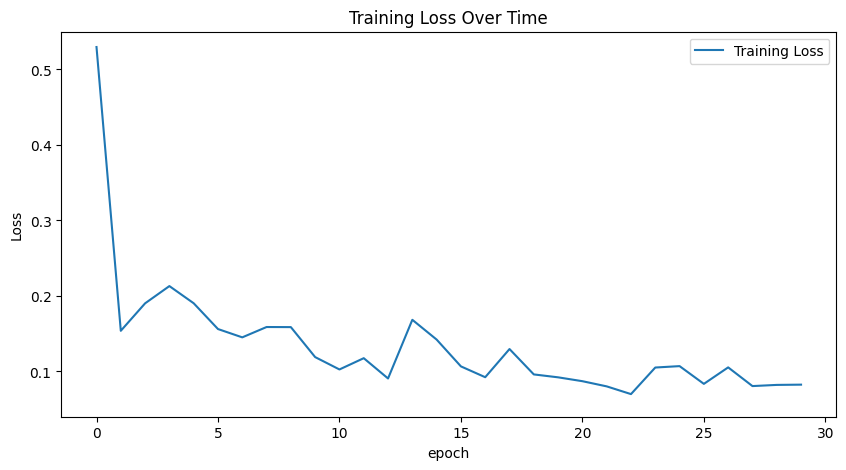

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.ylim(0.04, 0.55)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

生成


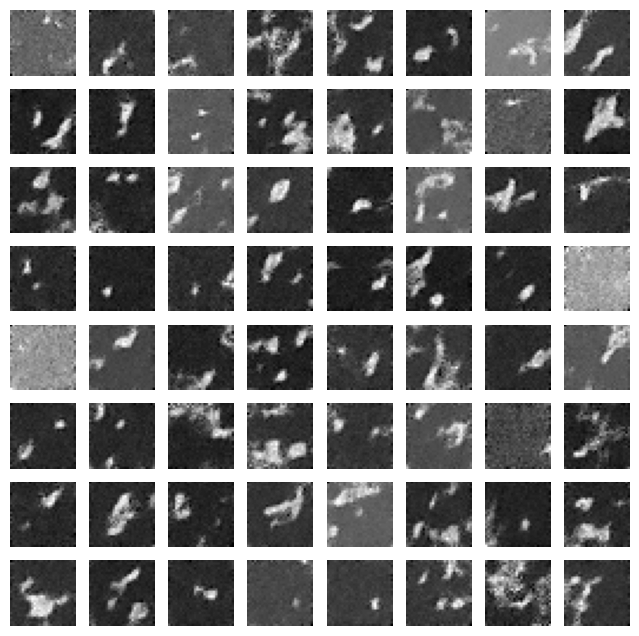

In [13]:

# 生成样本并可视化
samples = sample(model, 28, batch_size=64)
samples = samples.cpu().numpy()
samples = (samples + 1) / 2.0  # 恢复到[0, 1]范围

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i, 0], cmap='gray')
    ax.axis('off')
plt.show()

In [22]:
from torchvision.utils import save_image
from google.colab import files
def add_gaussian_noise(image, std_dev):
    noise = np.random.normal(loc=0, scale=std_dev, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# 添加加性高斯雜訊

def save_original_images(images):
    save_image(images, 'original_images.png', nrow=8)
    files.download('original_images.png')

# 儲存生成的圖像函數
def save_generated_images(images):
    save_image(images, 'generated_images.png', nrow=8)
    files.download('generated_images.png')
def save_noise_images(images):
    save_image(images, 'noise_images.png', nrow=8)
    files.download('noise_images.png')
model.eval()
original_images = next(iter(train_loader))[0][:32].to(device)  # 取出第一個 batch 的原始圖像
noiseimage=add_gaussian_noise(original_images.cpu().numpy() ,1.5)

noiseimage=torch.from_numpy(noiseimage).float()
# 生成圖像
with torch.no_grad():
    generated_images = model(noiseimage, torch.full((32,), timesteps-1, dtype=torch.long, device=device))
save_original_images(original_images)
save_noise_images(noiseimage)
save_generated_images(generated_images)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>